In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import scipy.linalg as la
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint_adjoint as odeint
from burgers import get_burgers, get_burgers_fd, set_initial_condition, analytical_burgers_1d
from graphic_tools import simple_plotter, show_state

---
# Burgers equation
---

## Analytical solution
Viscous Burgers equation in 1D is given by:
$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$
with $x \in [a, b]$ and $0 < t \leq T$.

We might start with initial conditions such as $u(x, 0) = u_0(t)$, $a=0, b=1.5, T=1$.

In [2]:
t_n = 50
x_n = 100
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.5
nu = 0.003

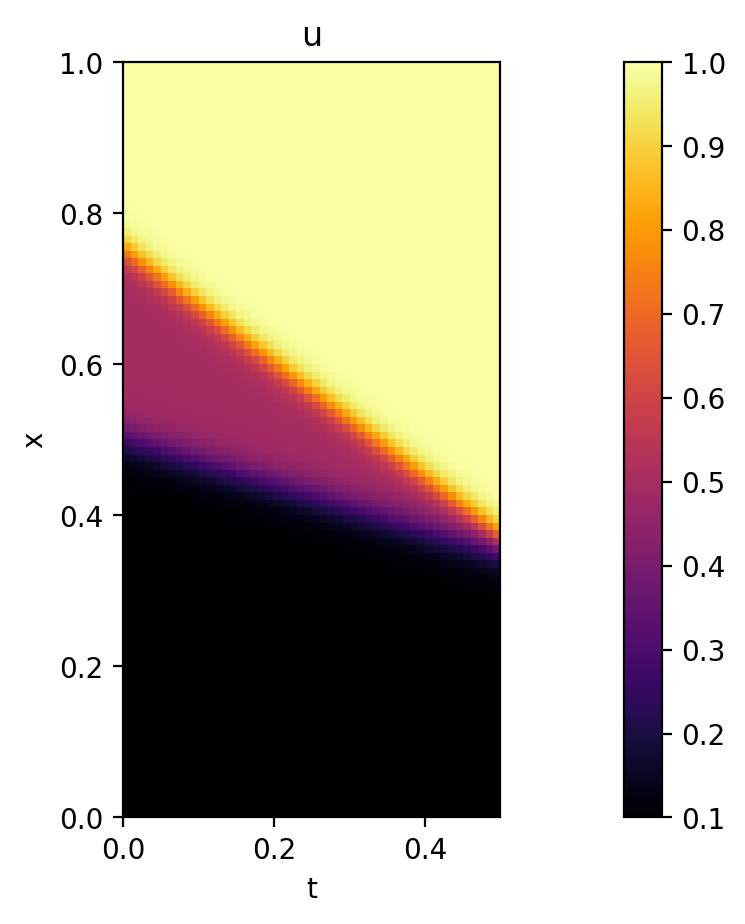

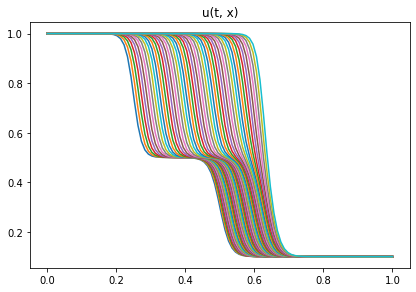

In [3]:
u_true = get_burgers(t_max, t_min, x_max, x_min, t_n, x_n, nu)
show_state(u_true.T, 'u', 't', 'x', [t_min, t_max, x_min, x_max])
simple_plotter(u_true, 'u(t, x)')

We discretize in domain space with $x_i = i \Delta x,\ i=\{0, \dots, N\}$ and $\Delta x = \frac{L}{N},\ L=b$ using finite difference method.

$u_{xx} = \frac{u_{i+1} - 2u_{i} + u_{i-1}}{(\Delta x)^2}$

$u_{x} = \frac{u_{i+1} - u_{i-1}}{2(\Delta x)}$

$u_{t} = \frac{u_{i+1} - u_{i}}{\Delta t}$

$u^{t+1}_{i} = u^{t}_{i} + \Delta t \Big(\nu \frac{u^{t}_{i+1} - 2 u^{t}_{i} + u^{t}_{i-1}}{(\Delta x)^2} - \frac{1}{4} u^{t}_{i} \frac{u^{t}_{i+1} - u^{t}_{i-1}}{\Delta x} \Big)$

In [1]:
t_n = 128
x_n = 128
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.2
nu = 0.0003

t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

u0 = high_dim_random_init(t, x)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'u', 't', 'x', None)
simple_plotter(u_df, 'u(t, x)')

NameError: name 'np' is not defined

In [78]:
def get_burgers_cons_df(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0):
    dt = (t_max - t_min) / t_n
    dx = (x_max - x_min) / x_n
    u = u0
    
    f = lambda u : np.power(u, 2) / 2
    
    for i in range(1, t_n):
        a  = (nu / dx**2) * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2])
        b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))
        u[i, 1:-1] = u[i-1, 1:-1] + dt * (a - b)
    
    return u

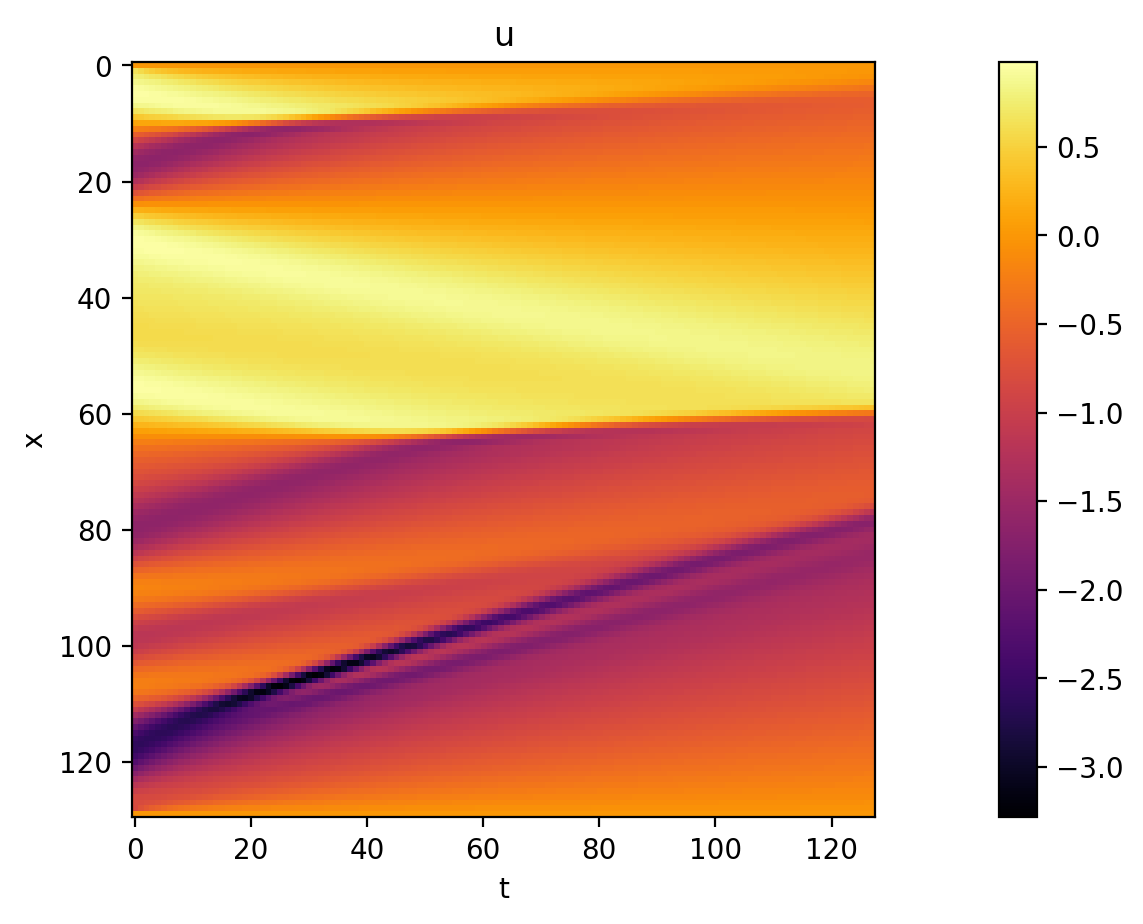

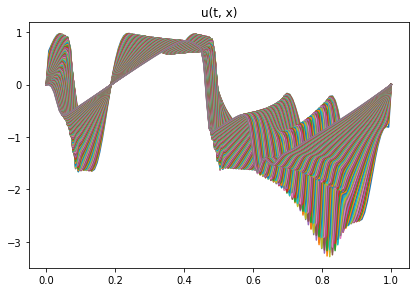

In [79]:
u_df_cons = get_burgers_cons_df(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df_cons.T, 'u', 't', 'x', None)
simple_plotter(u_df_cons, 'u(t, x)')

In [41]:
def get_D(X, s):

    d = np.zeros((X, X))
    for i in range(X):
        d[i][i] = 1 - s
        
    for i in range(X-1):
        d[i][i+1] = s / 2
        d[i+1][i] = s / 2
    
    return d

In [42]:
def get_M(X, u, dt, dx, nu):
    M = np.zeros((X, X))
    s = nu * dt / dx**2
    b = 1 + s
    
    for i in range(X):
        M[i][i] = b
    
    for i in range(X-1):
        M[i+1][i] = -dt / (4 * dx) * u[i-1] - s / 2
        M[i][i+1] = dt / (4 * dx) * u[i+1] - s / 2
    
    return M

In [67]:
def get_burgers_nicolson(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0):
    dt = (t_max - t_min) / t_n
    dx = (x_max - x_min) / x_n
    
    u = np.zeros((t_n, x_n))
    s = nu * dt / dx**2
    d = get_D(x_n, s)
    u_old = u0[0, 1:-1]
    u[0, :] = u_old
    
    for i in range(1, t_n):
        b = d @ u[i-1, :]
        m = get_M(x_n, u[i-1, :], dx, dt, nu)
        u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
        
    return u

<ipython-input-39-b82b7eb5d66d>:6: RuntimeWarning: overflow encountered in power
  f = lambda u : np.power(u, 2) / 2
<ipython-input-39-b82b7eb5d66d>:10: RuntimeWarning: invalid value encountered in subtract
  b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))
<ipython-input-39-b82b7eb5d66d>:11: RuntimeWarning: invalid value encountered in subtract
  u[i, 1:-1] = u[i-1, 1:-1] + dt * (a - b)


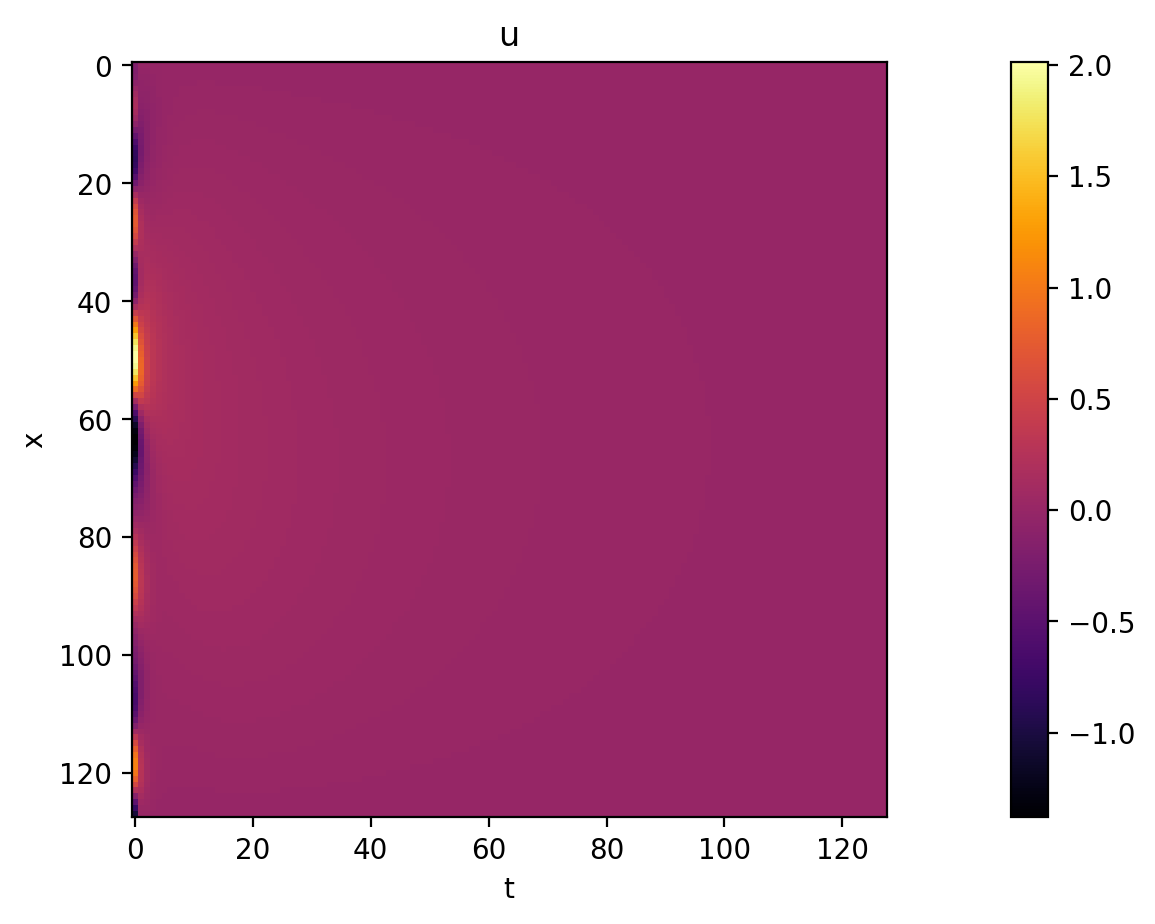

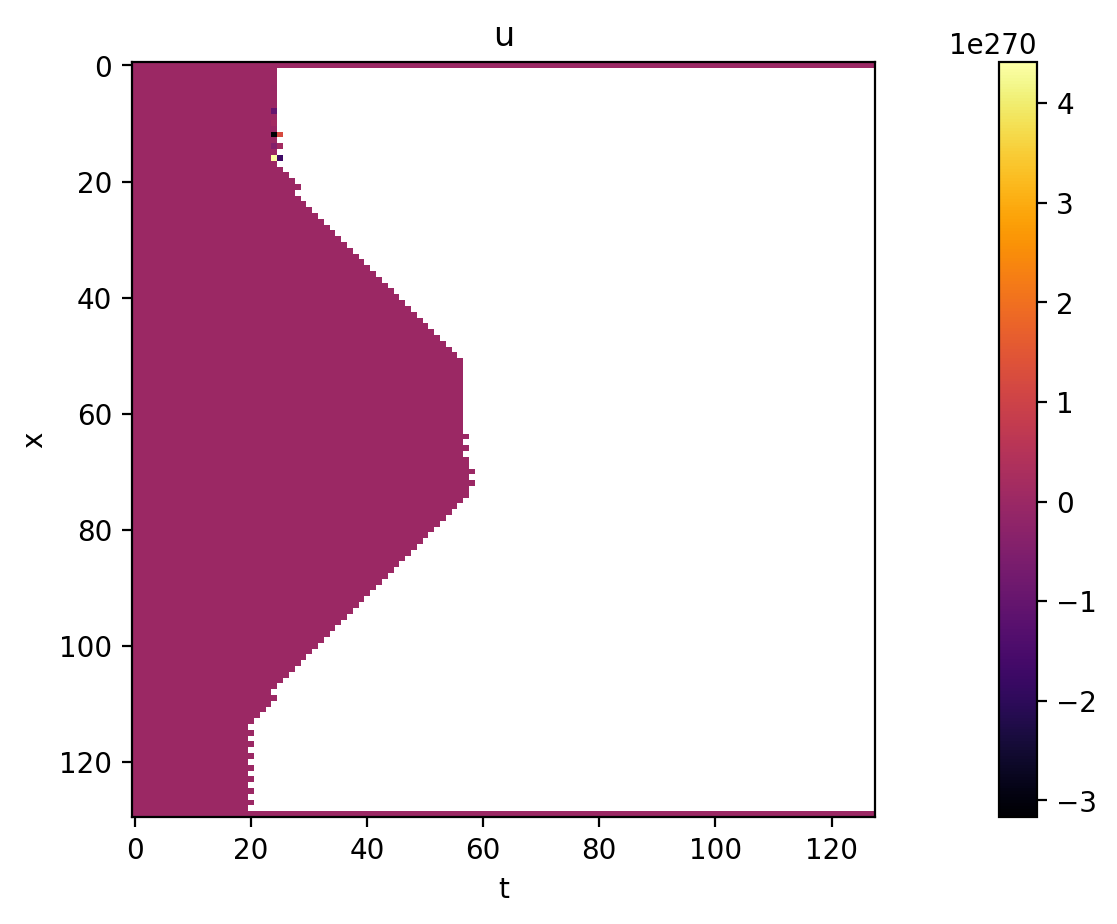

In [76]:
t_n = 128
x_n = 128
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.2
nu = 0.03

t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

u0 = high_dim_random_init(t, x)
u_nicol = get_burgers_nicolson(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_nicol.T, 'u', 't', 'x', None)

u_df_cons = get_burgers_cons_df(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df_cons.T, 'u', 't', 'x', None)

In [ ]:
def relative_err(u_a, u_b):
    return np.true_divide(np.abs(u_a - u_b), np.abs(u_a))

In [ ]:
def test_relative_err(t_max, t_min, x_max, x_min, t_n, x_n, nu, debug=True):
    dt = (t_max - t_min) / t_n
    dx = (x_max - x_min) / x_n
    err = np.zeros((t_n, x_n))
    
    u0 = set_initial_condition(t_max, t_min, x_max, x_min, t_n, x_n, nu)
    u_ex = get_burgers(t_max, t_min, x_max, x_min, t_n, x_n, nu)
    u_fd = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
    err = relative_err(u_ex, u_fd)
    
    if debug:
        show_state(u_ex, 'u_ex')
        show_state(u_fd, 'u_fd')
    
    return err

In [ ]:
err = test_relative_err(t_max, t_min, x_max, x_min, 100, 100, 0.003, debug=False)
show_state(err, 'Relative error', 't', 'x', None)

In [ ]:
err = relative_err(u_df, u_df_cons)
show_state(np.abs(u_df - u_df_cons), 'Non-conservative vs. conservative form', 't', 'x', None)

--- 
## Reconstruction analysis

Let's make a set of initial conditions which will be used for references and training

### Initial conditions

#### Gaussian initial conditions

In [ ]:
def gaussian_init(t, x):
    u = np.zeros((t.shape[0], x.shape[0] + 2))
    u[0, 1:-1] = np.exp(-(x - 1)**2)
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

#### Analytical solution as initial conditions

In [ ]:
def analytical_init(t, x, nu):
    u = np.zeros((t.shape[0], x.shape[0] + 2))

    u_true = analytical_burgers_1d(t[:, None], x[None, :], nu)
    u[0, 1:-1] = u_true[0, :]
    u[:, 0] =  u_true[:, 0]
    u[:, -1] = u_true[:, -1]

    return u

#### Stochastic initial conditions

In [ ]:
def random_init(t, x):
    """
    Random initial conditions
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    Forcing term f = 0
    """
    u = np.zeros((t.shape[0], x.shape[0] + 2))
    nu = np.random.normal(0, 0.25, x.shape[0])
    u[0, 1:-1] = np.sin(x) + nu
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

In [ ]:
def random_forcing(t, x):
    """
    Random forcing term
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    Forcing term f = 0
    """
    eps = np.random.normal(0, np.pi / 10, t.shape[0])
    f = eps * np.sin(t)
    return f

#### High-dimensional random initial conditions

In [5]:
def high_dim_random_init(t, x):
    """
    High-dimensional random initial conditions
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    """
    m = 48
    nu = np.random.normal(0, 1, 2 * m)
    u = np.zeros((t.shape[0], x.shape[0] + 2))
    
    s = [(nu[2 * k - 1] * np.sin(k * x)) + (nu[2 * k - 2] * np.cos(k * x)) for k in range(1, m+1)]
    
    u[0, 1:-1] = (1 / np.sqrt(m)) * np.sum(s, axis=0)
    u[:, 0] =  0
    u[:, -1] = 0

    return u

#### High-dimensional random forcing

In [ ]:
def high_dim_random_forcing(t, x):
    C = exp_cov_func(6)

In [ ]:
def exp_cov_func(n=6):
    lc = 0.01
    x = np.linspace(0, 5, n)[:, None]
    y = np.linspace(0, 5, n)[None, :]
    C = (1. / lc) * np.exp(-np.abs(x - y) / lc)
    
    return C

#### Shock initial conditions

In [ ]:
def shock_init(t, x):
    """
    High-dimensional random forcing - initial conditions
    """
    lc = 0.01
    m = 6
    nu = np.random.normal(0, 0.25, x.shape[0])
    l = np.zeros(x.shape[0])
    phi = np.zeros(x.shape[0])
    
    C = exp_cov_func(m) # to review
    U, phi, vh = np.linalg.svd(C)
    
    u[0, 1:-1] = a0 * (nu[0] * np.sin(x)) + np.sum([np.sqrt(l[k]) * nu[k] * phi[k][x] for k in range(1, m)])
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

In [ ]:
def shock_forcing(t, x):
    """
    High-dimensional random forcing - forcing term f
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    """
    m = 5
    eps = np.random.normal(0, 0.05, 2 * m)
    f = 1 + np.sum([(-1)**k * (eps[2*k] * np.sin(2 * k * x) + eps[2*k + 1] * np.cos(3 * k * x)) * np.exp(-np.sin(2 * k * t)) for k in range(0, m)])
    return f

### Full-Order Model (FOM)

In [82]:
t_n = 4096
x_n = 4096
x_min = 0.
x_max = 1.0
t_min = 0.001
t_max = 0.2
nu = 0.0003
t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

In [ ]:
u0 = analytical_init(t, x, nu)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - analytical initial conditions', 't', 'x', None) # [t_min, t_max, x_min, x_max]

In [ ]:
u0 = gaussian_init(t, x)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - Gaussian initial conditions', 't', 'x', None)

In [ ]:
u0 = random_init(t, x)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - random initial conditions', 't', 'x', None)

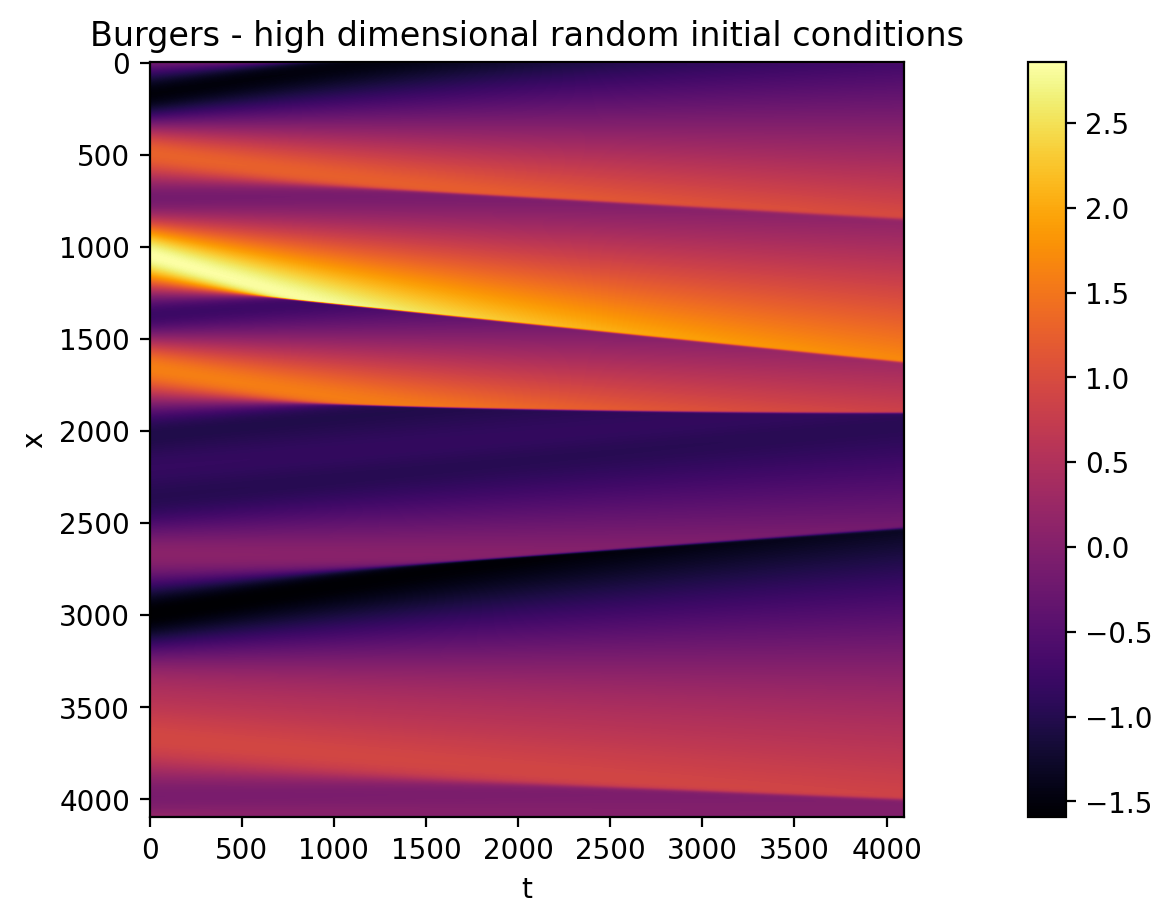

In [83]:
try:
    u0 = high_dim_random_init(t, x)
    u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
    if np.isfinite(u_df).sum() != (u_df.shape[0] * u_df.shape[1]):
        raise Exception('non finite')
    show_state(u_df.T, 'Burgers - high dimensional random initial conditions', 't', 'x', None)
except:
    print('Non finite')

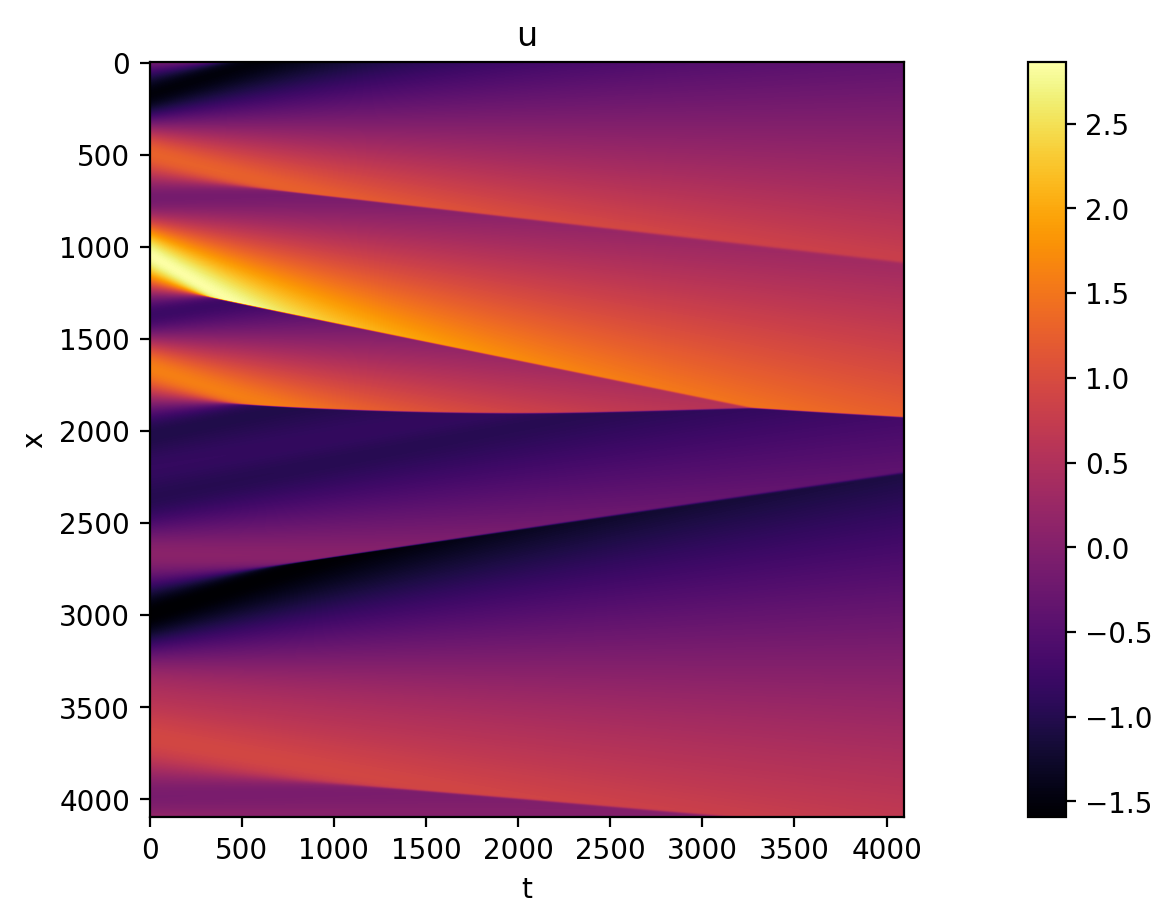

In [84]:
u_df = get_burgers_cons_df(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'u', 't', 'x', None)

---

### Reduce order model (ROM)

#### Basic downsampling

In [85]:
def downsampling(u, d=64):
    """
    @param u: snapshot
    @param d: interval of downsampling. Default 64
    """
    n, m = u.shape[0] // d, u.shape[1] // d
    d_u = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            d_u[i][j] = np.mean(u[i*d:(i+1)*d, j*d:(j+1)*d])
    
    return d_u

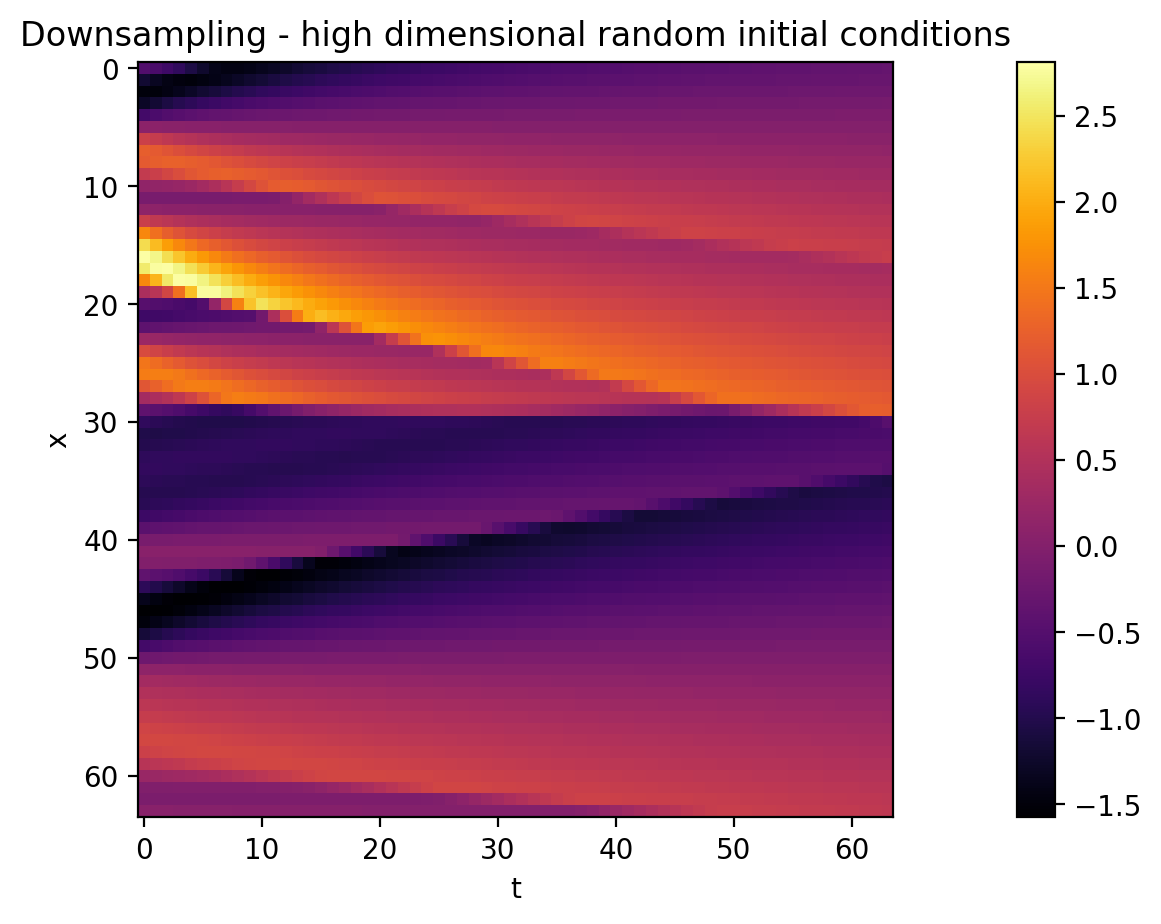

In [86]:
d_u = downsampling(u_df, 64)
show_state(d_u.T, 'Downsampling - high dimensional random initial conditions', 't', 'x', None)

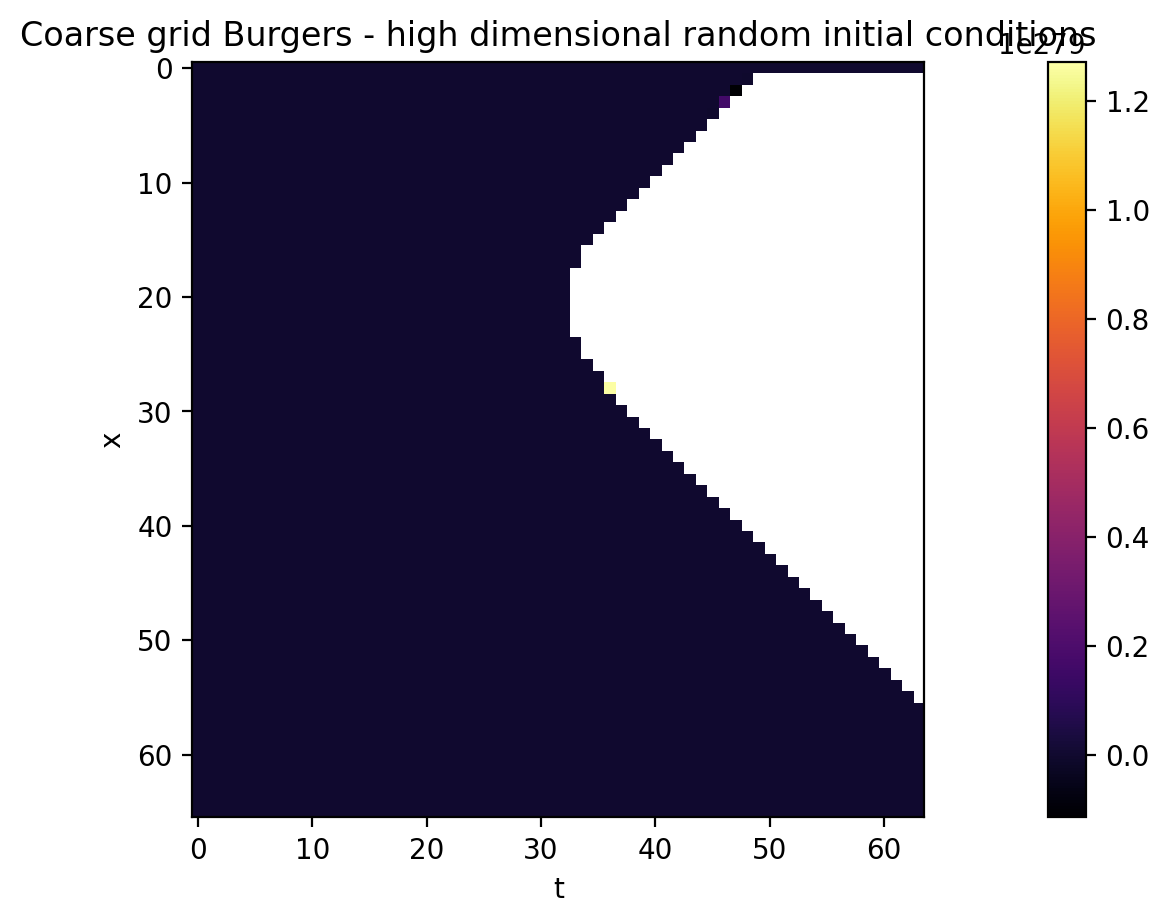

In [91]:
# todo - Implement other resolution method to handle instability
u02 = np.zeros((64, 66))
u02[:, 1:-1] = u0[::64, 1:-2:64]
coarse_u = get_burgers_fd(t_max, t_min, x_max, x_min, 64, 64, nu, u02)
show_state(coarse_u.T, 'Coarse grid Burgers - high dimensional random initial conditions', 't', 'x', None)

<ipython-input-78-b82b7eb5d66d>:6: RuntimeWarning: overflow encountered in power
  f = lambda u : np.power(u, 2) / 2
<ipython-input-78-b82b7eb5d66d>:10: RuntimeWarning: invalid value encountered in subtract
  b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))
<ipython-input-78-b82b7eb5d66d>:9: RuntimeWarning: invalid value encountered in subtract
  a  = (nu / dx**2) * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2])
<ipython-input-78-b82b7eb5d66d>:9: RuntimeWarning: invalid value encountered in add
  a  = (nu / dx**2) * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2])
/usr/local/lib/python3.9/site-packages/matplotlib/image.py:449: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.9/site-packages/matplotlib/image.py:454: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


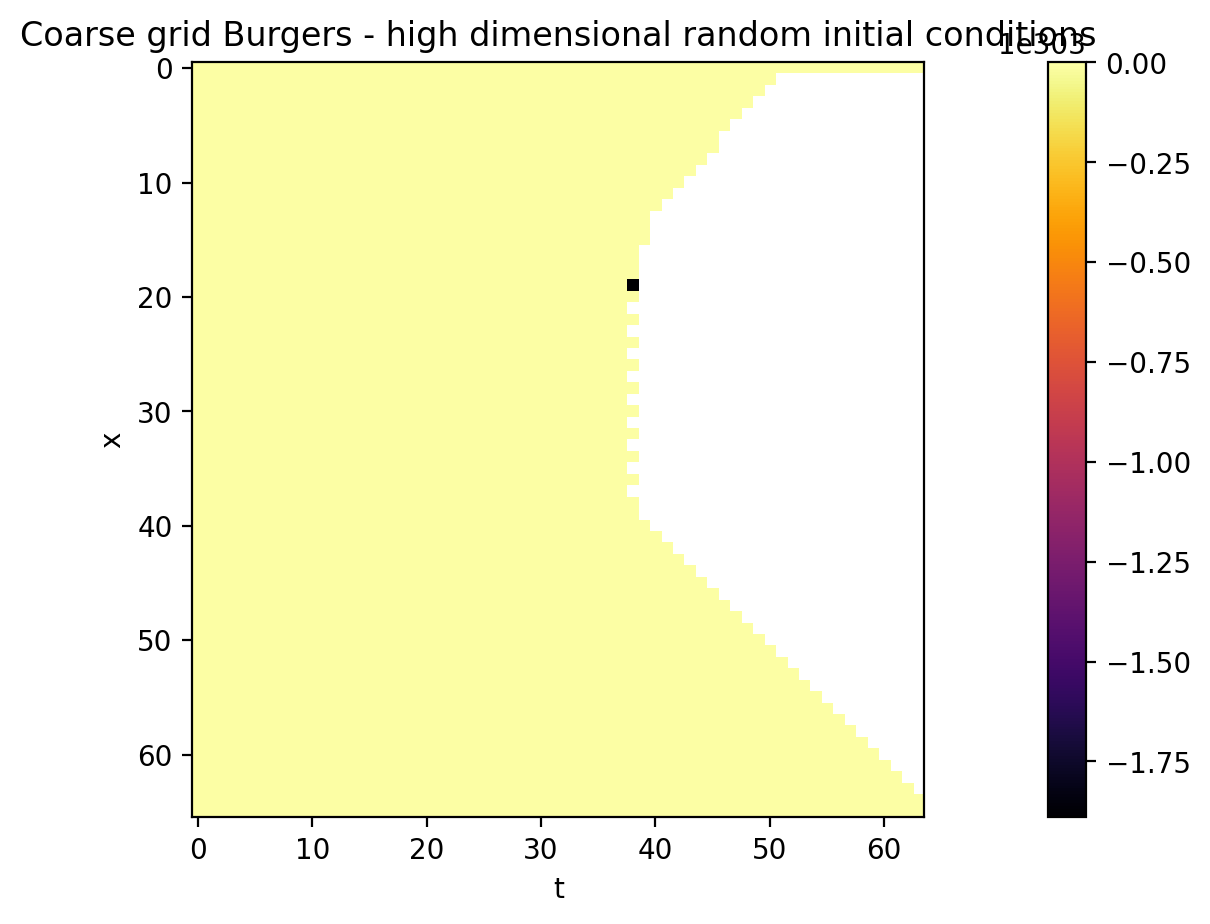

In [92]:
coarse_u_cons = get_burgers_cons_df(t_max, t_min, x_max, x_min, 64, 64, nu, u02)
show_state(coarse_u_cons.T, 'Coarse grid Burgers - high dimensional random initial conditions', 't', 'x', None)

In [93]:
coarse_u_nicol = get_burgers_nicolson(t_max, t_min, x_max, x_min, 64, 64, nu, u02)
show_state(coarse_u_nicol.T, 'Coarse grid Burgers - high dimensional random initial conditions', 't', 'x', None)

<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond=3.90663e-21): result may not be accurate.
  u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond=3.83045e-20): result may not be accurate.
  u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond=3.51435e-24): result may not be accurate.
  u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond=2.43182e-30): result may not be accurate.
  u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond=2.14318e-31): result may not be accurate.
  u[i, :] = la.solve(m, b, sym_pos=False, check_finite=True)
<ipython-input-67-9f0e09209827>:14: LinAlgWarning: Ill-conditioned matrix (rcond

ValueError: array must not contain infs or NaNs

In [ ]:
err = relative_err(d_u, coarse_u)
show_state(err.T, 'Relative error', 't', 'x', None)

#### POD

#### Penalty method